# Gemini Flamingos-2 reduction using DRAGONS Python API
***
## Public archival data from f2img_tutorial - GS-2013B-Q-15 (WISE J041358.14-475039.3)
#### adapted from https://dragons.readthedocs.io/projects/f2img-drtutorial/en/v3.0.3/03_api_reduction.html
#### don't forget to `conda install -n dragons nb_conda_kernels ipykernel` to run this notebook on the DRAGONS env 
***

**Importing Python Libraries** (you'll probably have to install the `wget` and `ipympl` libraries)

In [1]:
from __future__ import print_function

import glob
import wget

from gempy.adlibrary import dataselect
from recipe_system import cal_service
from recipe_system.reduction.coreReduce import Reduce
from gempy.utils import logutils

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.colors import PowerNorm

from collections import namedtuple

#%matplotlib widget
%matplotlib inline

**Downloading the data** (direct link to .tar file hosted at Gemini - 125 Megabytes)

In [ ]:
# uncomment the line and run the cell
#
#wget.download("http://www.gemini.edu/sciops/data/software/datapkgs/f2img_tutorial_datapkg-v1.tar")

**Downloading the data** (individual files - direct link to the Gemini Archive - 577 Megabytes)

In [ ]:
# # uncomment the lines and run the cell

# # Science 

# wget.download("http://archive.gemini.edu/file/S20131121S0075.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0076.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0077.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0078.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0079.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0080.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0081.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0082.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0083.fits")

# # Darks (2 s, short darks for BPM)

# wget.download("http://archive.gemini.edu/file/S20131121S0369.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0370.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0371.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0372.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0373.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0374.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0375.fits")

# # Darks (120 s, for science data)

# wget.download("http://archive.gemini.edu/file/S20131120S0115.fits")
# wget.download("http://archive.gemini.edu/file/S20131120S0116.fits")
# wget.download("http://archive.gemini.edu/file/S20131120S0117.fits")
# wget.download("http://archive.gemini.edu/file/S20131120S0118.fits")
# wget.download("http://archive.gemini.edu/file/S20131120S0119.fits")
# wget.download("http://archive.gemini.edu/file/S20131120S0120.fits")
# wget.download("http://archive.gemini.edu/file/S20131121S0010.fits")
# wget.download("http://archive.gemini.edu/file/S20131122S0012.fits")
# wget.download("http://archive.gemini.edu/file/S20131122S0438.fits")
# wget.download("http://archive.gemini.edu/file/S20131122S0439.fits")

# # Flats (20 s, Lamp On, Y-band)

# wget.download("http://archive.gemini.edu/file/S20131129S0320.fits")
# wget.download("http://archive.gemini.edu/file/S20131129S0321.fits")
# wget.download("http://archive.gemini.edu/file/S20131129S0322.fits")
# wget.download("http://archive.gemini.edu/file/S20131129S0323.fits")

# # Flats (20 s, Lamp Off, Y-band)

# wget.download("http://archive.gemini.edu/file/S20131126S1111.fits")
# wget.download("http://archive.gemini.edu/file/S20131126S1112.fits")
# wget.download("http://archive.gemini.edu/file/S20131126S1113.fits")
# wget.download("http://archive.gemini.edu/file/S20131126S1114.fits")
# wget.download("http://archive.gemini.edu/file/S20131126S1115.fits")
# wget.download("http://archive.gemini.edu/file/S20131126S1116.fits")


**Create and move data to raw/ directory** (uncomment first)

In [ ]:
#!mkdir raw/
#!mv S2013*.fits raw/

In [ ]:
# Check header of one raw science image
#
tmp = fits.open("raw/S20131121S0075.fits")
tmp[0].header

**Setting up the DRAGONS logger**

In [ ]:
logutils.config(file_name='f2_data_reduction.log')

**Setting up the Calibration Service**

First, check that you have already a `rsys.cfg` file inside the `~/.geminidr/`. It should contain:

```
[calibs]
standalone = True
database_dir = /path_to_this_folder/
```

In [ ]:
caldb = cal_service.CalibrationService()
caldb.config()
caldb.init()

cal_service.set_calservice()

**Create a list of all the FITS files in the directory**

In [ ]:
all_files = glob.glob('raw/S2013*[0-9].fits')
all_files.sort()
#all_files

**List of darks, flats, and science frames**

In [ ]:
dark_files_120s = dataselect.select_data(
    all_files,['F2', 'DARK', 'RAW'],[],
    dataselect.expr_parser('exposure_time==120'))

dark_files_2s = dataselect.select_data(
    all_files,['F2', 'DARK', 'RAW'],[],
    dataselect.expr_parser('exposure_time==2'))

list_of_flats_Y = dataselect.select_data(
     all_files,['FLAT'],[],
     dataselect.expr_parser('filter_name=="Y"'))

list_of_science_images = dataselect.select_data(
    all_files,['F2'],[],
    dataselect.expr_parser('(observation_class=="science" and filter_name=="Y")'))

**Create Master Dark and add to the calibration database**

In [ ]:
reduce_darks = Reduce()
reduce_darks.files.extend(dark_files_120s)
reduce_darks.runr()

caldb.add_cal(reduce_darks.output_filenames[0])

**Create Bad Pixel Mask**

In [ ]:
reduce_bpm = Reduce()
reduce_bpm.files.extend(list_of_flats_Y)
reduce_bpm.files.extend(dark_files_2s)
reduce_bpm.recipename = 'makeProcessedBPM'
reduce_bpm.runr()

bpm_filename = reduce_bpm.output_filenames[0]

**Create Master Flat Field and add to the calibration database**

In [ ]:
reduce_flats = Reduce()
reduce_flats.files.extend(list_of_flats_Y)
reduce_flats.uparms = [('addDQ:user_bpm', bpm_filename)]
reduce_flats.runr()

caldb.add_cal(reduce_flats.output_filenames[0])

**Reduce Science Images**

In [ ]:
reduce_target = Reduce()
reduce_target.files.extend(list_of_science_images)
reduce_target.uparms = [('addDQ:user_bpm', bpm_filename)]
reduce_target.runr()

**Display the Stacked Image**

In [2]:
image_file = "S20131121S0075_stack.fits"
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: S20131121S0075_stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     217   ()      
  1  SCI           1 ImageHDU        79   (2214, 2214)   float32   
  2  VAR           1 ImageHDU        79   (2214, 2214)   float32   
  3  DQ            1 ImageHDU        81   (2214, 2214)   int16 (rescales to uint16)   
  4  PROVENANCE    1 BinTableHDU     21   11R x 4C   [28A, 128A, 128A, 128A]   
  5  PROVHISTORY    1 BinTableHDU     21   21R x 4C   [128A, 427A, 28A, 28A]   


In [3]:
image_data = fits.getdata(image_file, ext=1)
print(image_data.shape)

(2214, 2214)


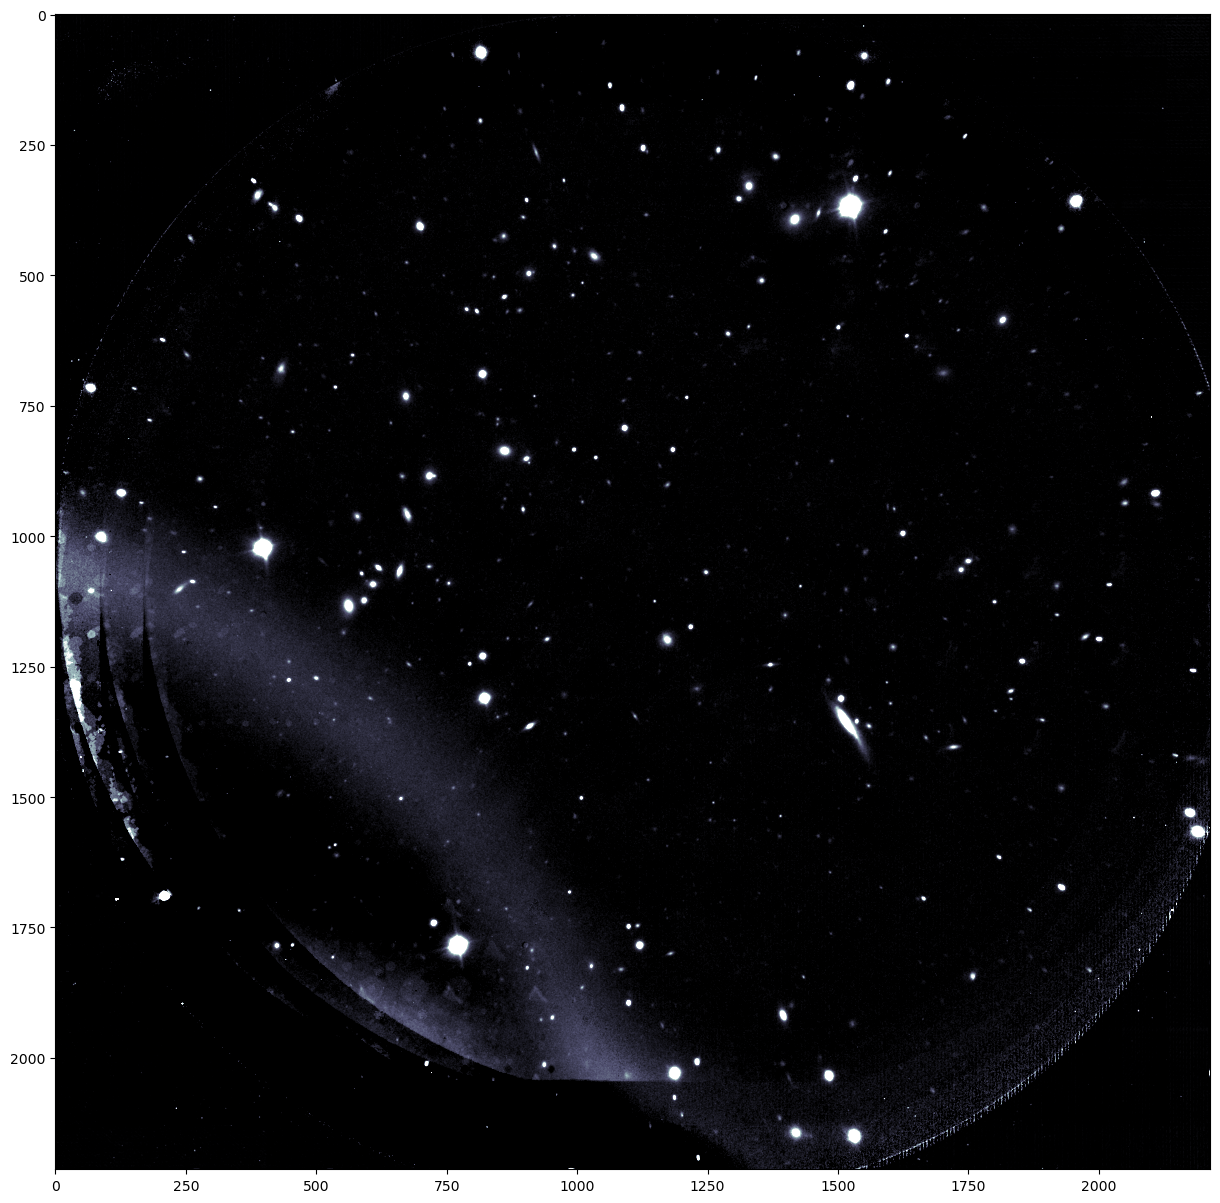

In [4]:
plt.figure(figsize = (15,15))
plt.imshow(image_data,cmap='bone',norm=Normalize(vmin=1, vmax=1000))
#plt.xlim(900,2500)
#plt.ylim(1600,600)
plt.show()

**Optional: remove raw data (uncomment lines before running)**

In [ ]:
#!rm -rf raw/